## Imports

In [167]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## The pure function

In [168]:
def build_up_b_pure(b, rho, dt, u, v, dx, dy):
    row, col = b.shape
    for i in range(1,row-1):
        for j in range(1,col-1):
            a0=rho*(dx*dy)
            a2=2*(dx**2+dy**2)
            a3=(4*dx*dx)
            a4=(4*dy*dx)
            a5=(4*dy*dy)
            a6=(u[i+1,j]-u[i-1,j])
            a7=(v[i,j+1]-v[i,j-1])
            a1=a6/(2*dx)+a7/(2*dy)
            a8=(u[i,j+1]-u[i,j-1])
            a9=(v[i+1,j]-v[i-1,j])
            b[i,j]=a0**2*(a1/dt-a6**2/a3-2*a8*a9/a4-a7**2/a5)/a2

    return b

def pressure_poisson_pure(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    row, col = b.shape
    p[0,:]=p[1,:]
    p[-1,:]=p[-2,:]
    p[:,0]=p[:,1]
    p[:,-1]=0
    for i in range(1,row-1):
        for j in range(1,col-1):
            p1=(pn[i+1,j]+pn[i-1,j])
            p2=(pn[i,j+1]+pn[i,j-1])
            p3=(p1*dy**2+p2*dy**2)
            p4=(2*(dx**2+dy**2))
            p[i,j]=p3/p4-b[i,j]
    
        
    return p

def cavity_flow_pure(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    #the initial condition at y=2
    u[:,-1]=1
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    row, col = b.shape
    for k in range(nt):
        un=u.copy()
        vn=v.copy()
        for i in range(1,row-1):
            for j in range(1,col-1):
                u[i,j]=un[i,j]-un[i,j]*dt*(un[i,j]-un[i,j-1])/dx-vn[i,j]*dt*(un[i,j]-un[i,j-1])/dy-dt*(p[i+1,j]-p[i-1,j])/(rho*2*dx)+nu*(dt*(un[i+1,j]-2*un[i,j]+un[i-1,j])/dx**2+dt*(un[i,j+1]-2*un[i,j]+un[i,j-1])/dy**2)
                v[i,j]=vn[i,j]-un[i,j]*dt*(vn[i,j]-vn[i,j-1])/dx-vn[i,j]*dt*(vn[i,j]-vn[i,j-1])/dy-dt*(p[i,j+1]-p[i,j-1])/(rho*2*dx)+nu*(dt*(vn[i+1,j]-2*vn[i,j]+vn[i-1,j])/dx**2+dt*(vn[i,j+1]-2*vn[i,j]+vn[i,j-1])/dy**2)
        b=build_up_b_pure(b, rho, dt, u, v, dx, dy)
        p=pressure_poisson_pure(p, dx, dy, b)
    
        
        
    return u, v, p

## Numba accelerated function

In [169]:
@njit(fastmath=True)
def build_up_b_pure(b, rho, dt, u, v, dx, dy):
    row, col = b.shape
    for i in range(1,row-1):
        for j in range(1,col-1):
            a0=(rho*(dx*dy))
            a2=(2*(dx**2+dy**2))
            a3=(4*dx*dx)
            a4=(4*dy*dx)
            a5=(4*dy*dy)
            a6=(u[i+1,j]-u[i-1,j])
            a7=(v[i,j+1]-v[i,j-1])
            a1=a6/(2*dx)+a7/(2*dy)
            a8=(u[i,j+1]-u[i,j-1])
            a9=(v[i+1,j]-v[i-1,j])
            b[i,j]=a0**2*(a1/dt-a6**2/a3-2*a8*a9/a4-a7**2/a5)/a2

    return b
@njit(fastmath=True)
def pressure_poisson_pure(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    row, col = b.shape
    p[0,:]=p[1,:]
    p[-1,:]=p[-2,:]
    p[:,0]=p[:,1]
    p[:,-1]=0
    for i in range(1,row-1):
        for j in range(1,col-1):
            p1=(pn[i+1,j]+pn[i-1,j])
            p2=(pn[i,j+1]+pn[i,j-1])
            p3=(p1*dy**2+p2*dy**2)
            p4=(2*(dx**2+dy**2))
            p[i,j]=p3/p4-b[i,j]
    
        
    return p
@njit(fastmath=True)
def cavity_flow_pure(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    #the initial condition at y=2
    u[:,-1]=1
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    row, col = b.shape
    for k in range(nt):
        un=u.copy()
        vn=v.copy()
        for i in range(1,row-1):
            for j in range(1,col-1):
                u[i,j]=un[i,j]-un[i,j]*dt*(un[i,j]-un[i,j-1])/dx-vn[i,j]*dt*(un[i,j]-un[i,j-1])/dy-dt*(p[i+1,j]-p[i-1,j])/(rho*2*dx)+nu*(dt*(un[i+1,j]-2*un[i,j]+un[i-1,j])/dx**2+dt*(un[i,j+1]-2*un[i,j]+un[i,j-1])/dy**2)
                v[i,j]=vn[i,j]-un[i,j]*dt*(vn[i,j]-vn[i,j-1])/dx-vn[i,j]*dt*(vn[i,j]-vn[i,j-1])/dy-dt*(p[i,j+1]-p[i,j-1])/(rho*2*dx)+nu*(dt*(vn[i+1,j]-2*vn[i,j]+vn[i-1,j])/dx**2+dt*(vn[i,j+1]-2*vn[i,j]+vn[i,j-1])/dy**2)
        b=build_up_b_pure(b, rho, dt, u, v, dx, dy)
        p=pressure_poisson_pure(p, dx, dy, b)
    
        
        
    return u, v, p

## Inputs

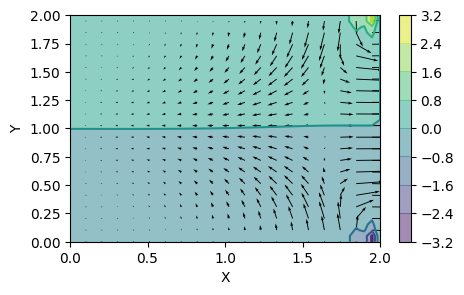

In [179]:


## Inputs

nx = 40
ny = 40
nt =400
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

u, v, p = cavity_flow_pure(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu)

fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y');

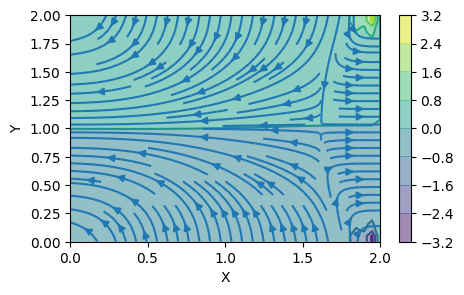

In [180]:
fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.streamplot(X, Y, u, v)
pyplot.xlabel('X')
pyplot.ylabel('Y');

## Pure python function

In [177]:
%timeit cavity_flow_pure(nt, u, v, dt, ny, ny, dx, dy, p, rho, nu)

4.73 ms ± 69.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Numba accelerator

In [181]:
%timeit cavity_flow_numba(nt, u, v, dt, ny, ny, dx, dy, p, rho, nu)

9.39 ms ± 36.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
